## Classifying customer satisfaction based on relevant factors

In [67]:
# import os
# # Path on master/worker where Python is installed
# os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3.0'

import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc
from pyspark.sql.functions import isnan, when, count, col
from matplotlib.pyplot import hist
import matplotlib.pyplot as plt

In [28]:
spark = SparkSession.builder.appName('customer-satisfaction-v1').getOrCreate()
df = spark.read.csv('hdfs://namenode/satisfaction.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- satisfaction_v2: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- Online support: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Onli

Gender: Gender of the passengers (Female, Male)

Customer Type: The customer type (Loyal customer, disloyal customer)

Age: The actual age of the passengers

Type of Travel: Purpose of the flight of the passengers (Personal Travel, Business Travel)

Class: Travel class in the plane of the passengers (Business, Eco, Eco Plus)

Flight distance: The flight distance of this journey

Inflight wifi service: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)

Departure/Arrival time convenient: Satisfaction level of Departure/Arrival time convenient

Ease of Online booking: Satisfaction level of online booking

Gate location: Satisfaction level of Gate location

Food and drink: Satisfaction level of Food and drink

Online boarding: Satisfaction level of online boarding

Seat comfort: Satisfaction level of Seat comfort

Inflight entertainment: Satisfaction level of inflight entertainment

On-board service: Satisfaction level of On-board service

Leg room service: Satisfaction level of Leg room service

Baggage handling: Satisfaction level of baggage handling

Check-in service: Satisfaction level of Check-in service

Inflight service: Satisfaction level of inflight service

Cleanliness: Satisfaction level of Cleanliness

Departure Delay in Minutes: Minutes delayed when departure

Arrival Delay in Minutes: Minutes delayed when Arrival

Satisfaction: Airline satisfaction level(Satisfaction, neutral or dissatisfaction)

## Basic information on dataset

In [29]:
print('Number of rows',df.count())
print('Number of columns',len(df.columns))
pd.DataFrame(df.take(5), columns=df.columns).transpose()

Number of rows 129880
Number of columns 24


,0,1,2,3,4
id,11112,110278,103199,47462,120011
satisfaction_v2,satisfied,satisfied,satisfied,satisfied,satisfied
Gender,Female,Male,Female,Female,Female
Customer Type,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer
Age,65,47,15,60,70
Type of Travel,Personal Travel,Personal Travel,Personal Travel,Personal Travel,Personal Travel
Class,Eco,Business,Eco,Eco,Eco
Flight Distance,265,2464,2138,623,354
Seat comfort,0,0,0,0,0
Departure/Arrival time convenient,0,0,0,0,0


Although the ratio of satisfaction to non-satisfaction is not 50:50, it is still close to a 60:40 making it acceptable 

In [30]:
df.groupby('satisfaction_v2').count().toPandas()

,satisfaction_v2,count
0,neutral or dissatisfied,58793
1,satisfied,71087


Summary of dataset below

In [31]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features[1:]).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Age,129880,39.42795657530028,15.119359950371688,7,85
Flight Distance,129880,1981.409054511857,1027.1156056133977,50,6951
Seat comfort,129880,2.838597166615337,1.3929832432699014,0,5
Departure/Arrival time convenient,129880,2.990645210963967,1.5272243703451138,0,5
Food and drink,129880,2.851994148444718,1.4437293865730387,0,5
Gate location,129880,2.990421927933477,1.3059698939850506,0,5
Inflight wifi service,129880,3.2491299661225748,1.3188175196680636,0,5
Inflight entertainment,129880,3.3834770557437635,1.3460591444981018,0,5
Online support,129880,3.519702802587003,1.3065106903517532,0,5


## Pre-processing to ensure there are no NaN or null values 

In [32]:
pdDf = df.toPandas()
is_NaN = pdDf.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = pdDf[row_has_NaN]
print(rows_with_NaN)

# can be seen that there are missing values, these will be filled with 
# median values coming from the same column

            id          satisfaction_v2  Gender      Customer Type  Age  \
145      61021                satisfied  Female     Loyal Customer   21   
246      40480                satisfied    Male     Loyal Customer   28   
710      19597                satisfied    Male     Loyal Customer   28   
736       5411                satisfied    Male     Loyal Customer    9   
818       3711  neutral or dissatisfied    Male     Loyal Customer    9   
...        ...                      ...     ...                ...  ...   
127739   40434                satisfied    Male     Loyal Customer   44   
128131  120101                satisfied    Male     Loyal Customer   39   
128710   45676                satisfied  Female     Loyal Customer   45   
129774   44820                satisfied    Male  disloyal Customer   49   
129873   46936                satisfied  Female  disloyal Customer   63   

         Type of Travel     Class  Flight Distance  Seat comfort  \
145     Personal Travel       E

## Analysis on dataset

### Age

,Age,count
36,39,3692
49,25,3511
18,40,3209
10,44,3104
24,41,3089
66,42,3017
26,43,2941
46,45,2939
37,23,2935
12,22,2931


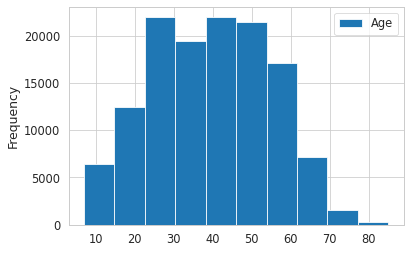

In [33]:
# this gives the exact count number of each age
age_count = df.groupby('Age').count().toPandas()

age_sample = df.select('Age').toPandas()
age_sample.plot.hist()
age_count.sort_values(by=['count'],ascending=False).head(10)

Interestingly, the age is fairly distributed and can be seen that most of the data points are coming from passengers aged between 20 to 50. Note that, this is not distinguished by anything.

Analyze age groups in different airline classes

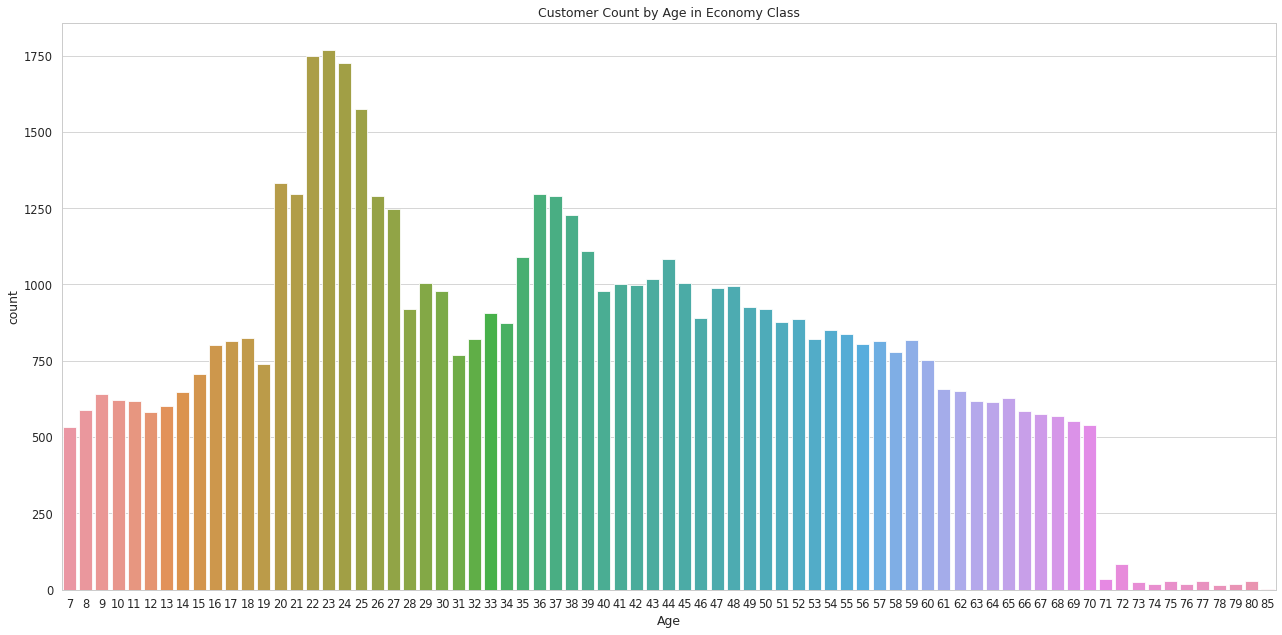

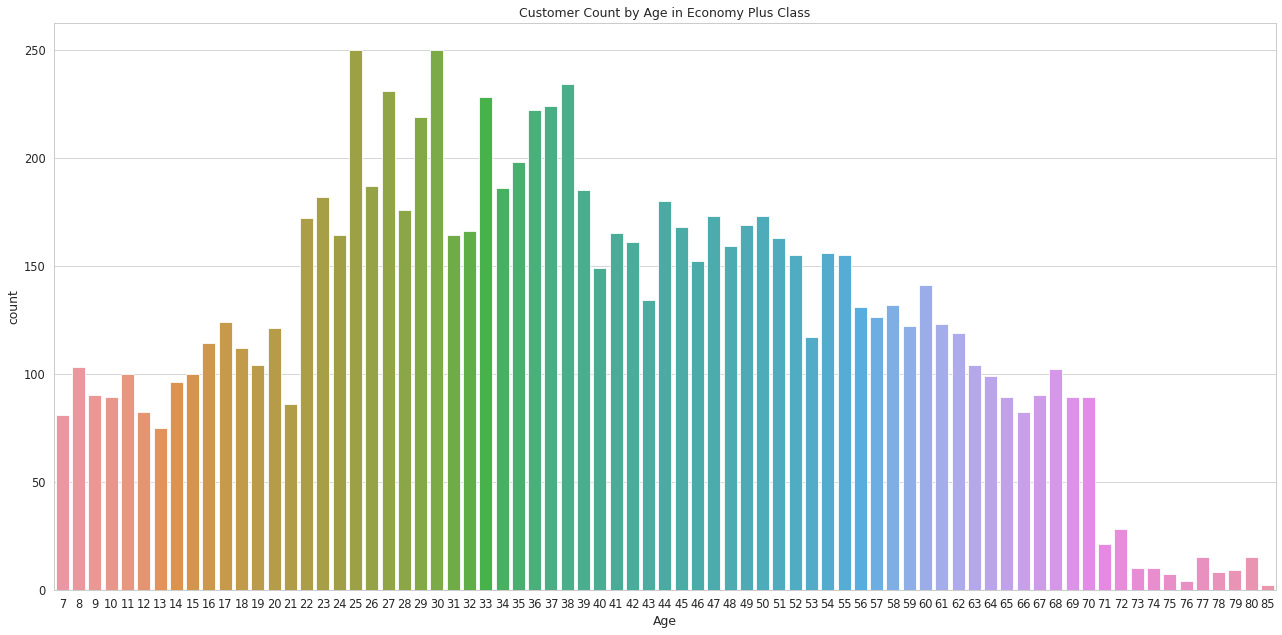

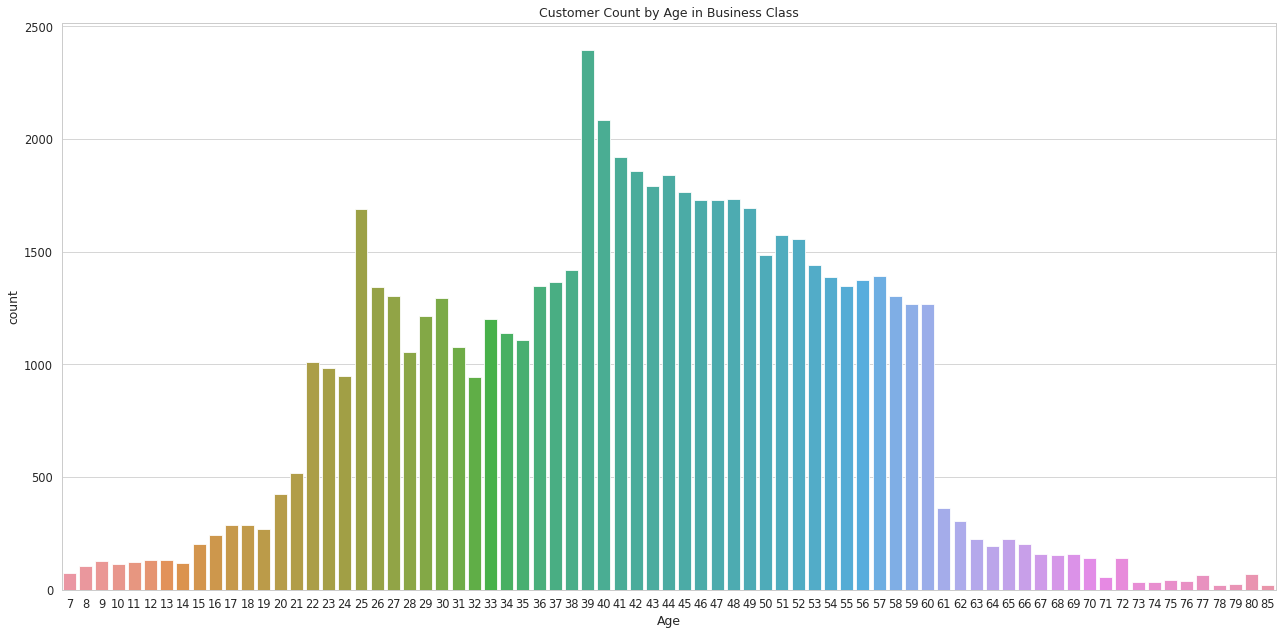

In [34]:
df_eco = pdDf[pdDf['Class']=='Eco']
df_eco1 = pdDf[pdDf['Class']=='Eco Plus']
df_bus = pdDf[pdDf['Class']=='Business']

# Show distribution graph each class by age (customer)
# for economy class
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.3)
fig,ax = plt.subplots(1,1,figsize=(18,9))
sns.countplot(data=df_eco,x='Age')
ax.set_title('Customer Count by Age in Economy Class')
plt.tight_layout()
plt.show()

# for economy plus class
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.3)
fig,ax = plt.subplots(1,1,figsize=(18,9))
sns.countplot(data=df_eco1,x='Age')
ax.set_title('Customer Count by Age in Economy Plus Class')
plt.tight_layout()
plt.show()

# for business class
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.3)
fig,ax = plt.subplots(1,1,figsize=(18,9))
sns.countplot(data=df_bus,x='Age')
ax.set_title('Customer Count by Age in Business Class')
plt.tight_layout()
plt.show()

In [35]:
print('Economy class sample size :',df_eco.shape[0])
print('Economy plus class sample size :',df_eco1.shape[0])
print('Business class sample size :',df_bus.shape[0])

Economy class sample size : 58309
Economy plus class sample size : 9411
Business class sample size : 62160


Notable observations. The economy class is dominated by passengers in the range 20-27 years while the business class is dominated by paseengers in range 39-49 years of age. Interestingly, the economy plus class is dominated by passengers in the age group of 22-39 years of age but it is the class that is the smallest in compared to the other 2 classes.

### Additional analysis

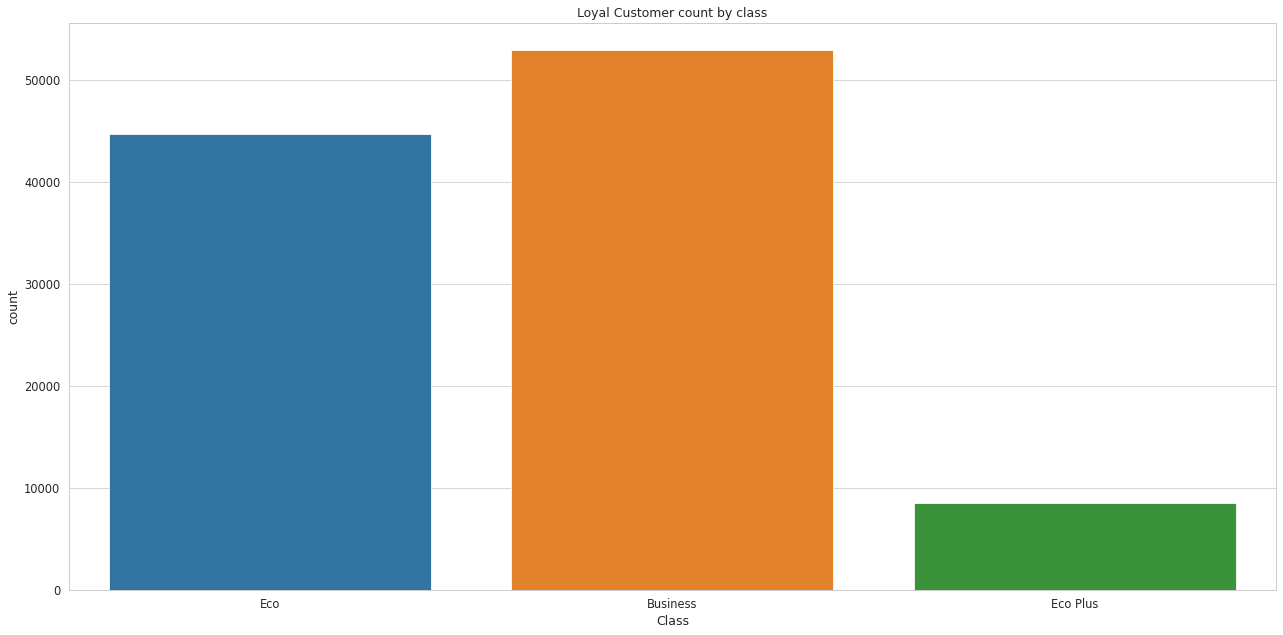

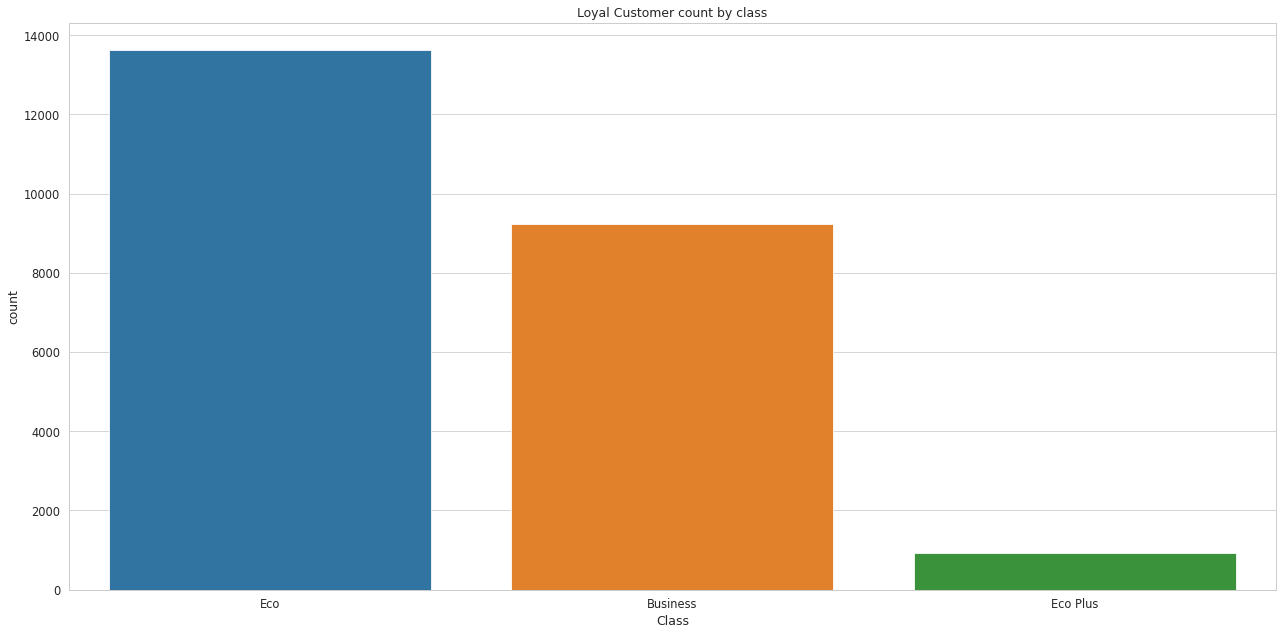

In [36]:
df_loyal_customers = pdDf[pdDf['Customer Type']=='Loyal Customer']
df_disloyal_customers = pdDf[pdDf['Customer Type']=='disloyal Customer']

# Distribution of class used by loyal customers
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.3)
fig,ax = plt.subplots(1,1,figsize=(18,9))
sns.countplot(data=df_loyal_customers,x='Class')
ax.set_title('Loyal Customer count by class')
plt.tight_layout()
plt.show()

# Distribution of class used by disloyal customers
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.3)
fig,ax = plt.subplots(1,1,figsize=(18,9))
sns.countplot(data=df_disloyal_customers,x='Class')
ax.set_title('Loyal Customer count by class')
plt.tight_layout()
plt.show()

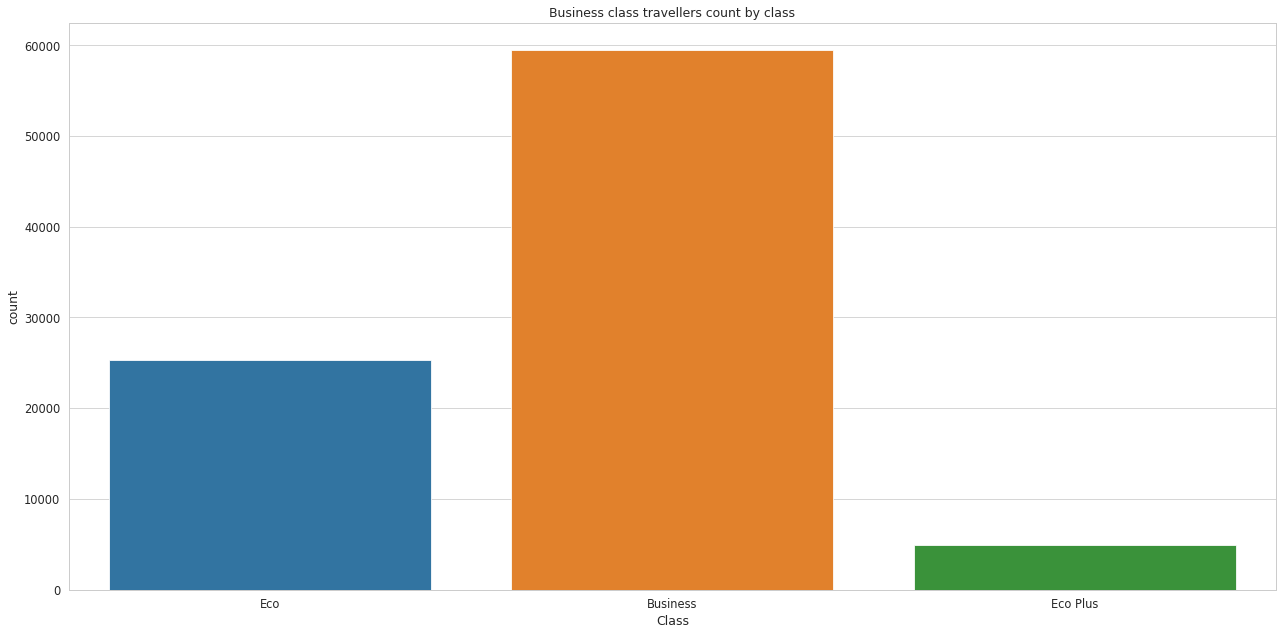

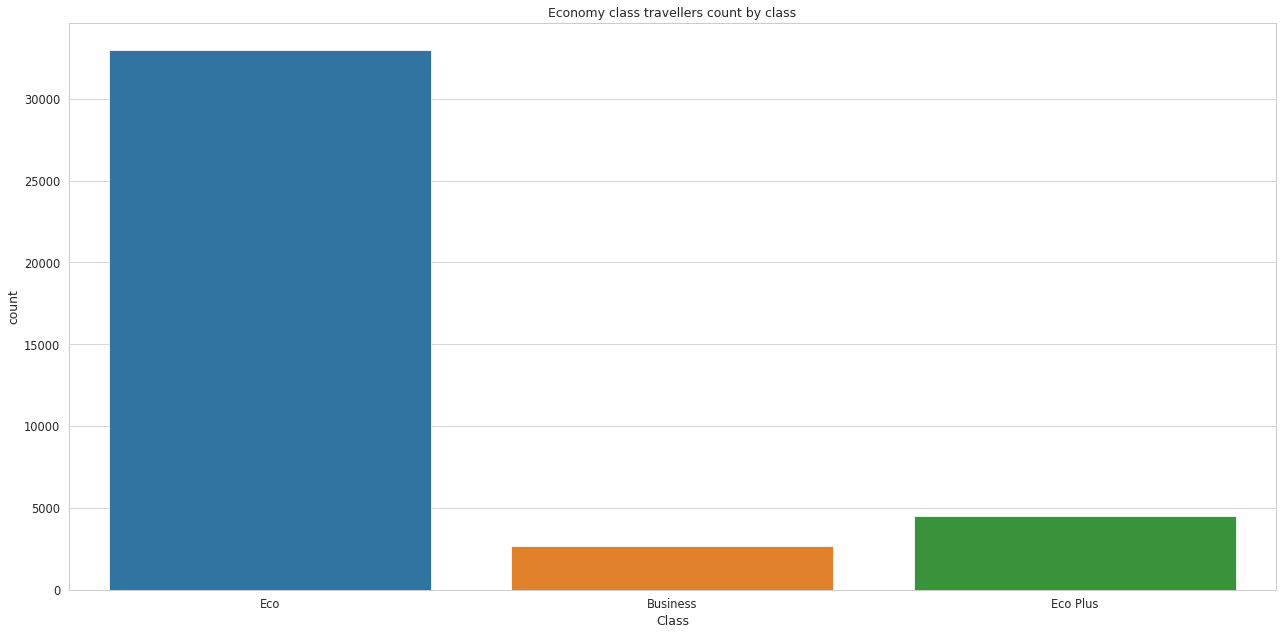

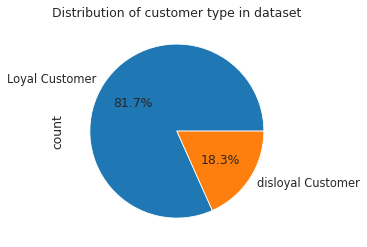

In [37]:
df_business_travellers = pdDf[pdDf['Type of Travel']=='Business travel']
df_personal_travellers = pdDf[pdDf['Type of Travel']=='Personal Travel']

# Distribution of travel type business by class
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.3)
fig,ax = plt.subplots(1,1,figsize=(18,9))
sns.countplot(data=df_business_travellers,x='Class')
ax.set_title('Business class travellers count by class')
plt.tight_layout()
plt.show()

# Distribution of travel type personal by class
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.3)
fig,ax = plt.subplots(1,1,figsize=(18,9))
sns.countplot(data=df_personal_travellers,x='Class')
ax.set_title('Economy class travellers count by class')
plt.tight_layout()
plt.show()

customer_type_stats = df.groupby('Customer Type').count().toPandas()
customer_type_stats.plot.pie(y='count', title='Distribution of customer type in dataset', labels=customer_type_stats['Customer Type'], legend=False, autopct='%1.1f%%')

Interesting observations - with 82% of the dataset consisting of customers which are loyal and of that 82%, it can be seen that loyal customers are more often then not using the business class. Whereas, disloyal customers are often using the economy class. Additionally, customers that are on business travel purpose would also oftenly utilize the business class whereas customers that are travelling for personal reasons would usually take the economy class.

In [38]:
pdDf = df.toPandas()
pdDf.sample(20)

,id,satisfaction_v2,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
128390,99032,satisfied,Male,Loyal Customer,14,Business travel,Business,5033,1,1,...,5,5,5,5,4,3,5,5,0,0.0
65413,39564,satisfied,Female,Loyal Customer,26,Business travel,Eco,2865,0,5,...,4,4,4,4,1,3,2,4,1,0.0
40905,32823,neutral or dissatisfied,Male,disloyal Customer,22,Business travel,Eco,1835,1,0,...,3,3,4,4,5,3,3,3,0,3.0
59005,47778,satisfied,Female,disloyal Customer,22,Business travel,Eco,2692,4,4,...,2,2,1,2,2,2,5,2,0,0.0
17998,54779,satisfied,Female,Loyal Customer,65,Personal Travel,Eco Plus,805,4,4,...,3,4,4,4,4,4,4,4,0,0.0
89411,56014,satisfied,Male,Loyal Customer,49,Business travel,Business,2525,4,4,...,4,5,3,4,5,4,4,4,0,0.0
109782,100664,satisfied,Male,Loyal Customer,39,Business travel,Business,683,5,5,...,4,5,5,4,5,4,5,5,0,0.0
108437,15862,satisfied,Female,Loyal Customer,52,Business travel,Business,2876,4,4,...,4,4,4,4,4,2,4,5,0,0.0
56701,43943,satisfied,Female,disloyal Customer,23,Business travel,Eco,1867,4,0,...,5,5,5,2,4,5,5,5,0,0.0
125075,27740,satisfied,Male,Loyal Customer,15,Business travel,Business,2820,3,3,...,5,5,4,1,4,2,4,5,0,0.0


## Correlations

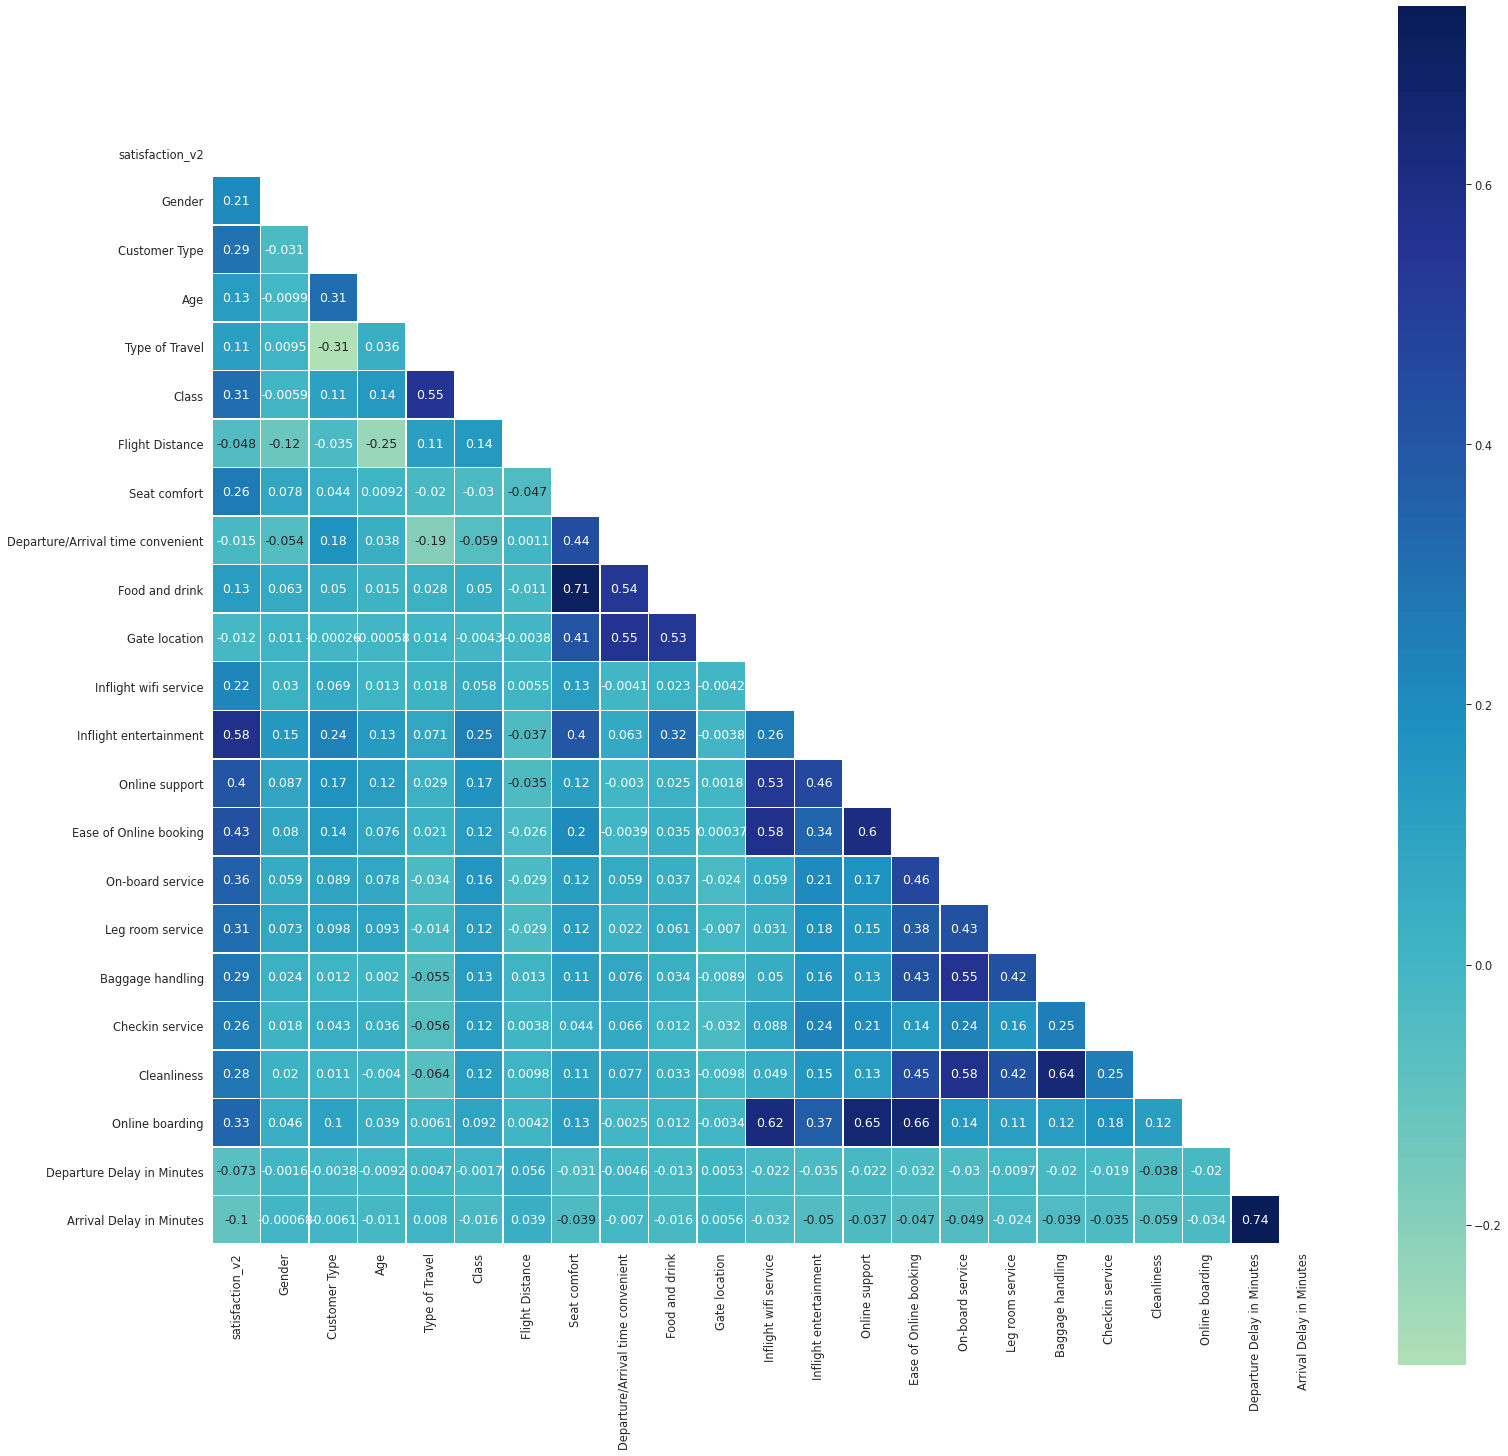

In [39]:
# the following functions are to transform strings to encoded values
# to be used to check correlation to satisfaction 
def transform_gender(x):
    if x == 'Female':
        return 1
    elif x == 'Male':
        return 0
    else:
        return -1
    
def transform_customer_type(x):
    if x == 'Loyal Customer':
        return 1
    elif x == 'disloyal Customer':
        return 0
    else:
        return -1
    
def transform_travel_type(x):
    if x == 'Business travel':
        return 1
    elif x == 'Personal Travel':
        return 0
    else:
        return -1
    
def transform_class(x):
    if x == 'Business':
        return 2
    elif x == 'Eco Plus':
        return 1
    elif x == 'Eco':
        return 0    
    else:
        return -1
    
def transform_satisfaction(x):
    if x == 'satisfied':
        return 1
    elif x == 'neutral or dissatisfied':
        return 0
    else:
        return -1

# we drop id column because it is not useful for model training
# and encode all relevant columns and fill empty values in arrival
# delay in minutes
def process_data(df):
    df = df.drop(['id'], axis = 1)
    df['Gender'] = df['Gender'].apply(transform_gender)
    df['Customer Type'] = df['Customer Type'].apply(transform_customer_type)
    df['Type of Travel'] = df['Type of Travel'].apply(transform_travel_type)
    df['Class'] = df['Class'].apply(transform_class)
    df['satisfaction_v2'] = df['satisfaction_v2'].apply(transform_satisfaction)
    df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median(), inplace = True)
    
    return df

processed_df = process_data(pdDf)

corr = processed_df.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap="YlGnBu", center=0,
            square=True, linewidths=.5)

Based on the heat map correlation, it can be concluded that:
The best features are : Ease of Online Booking, Class and Type of Travel and
The worst features are : Gate location, Gender, and Departure/Arrival Time Convenient. We shall drop the features which are worst


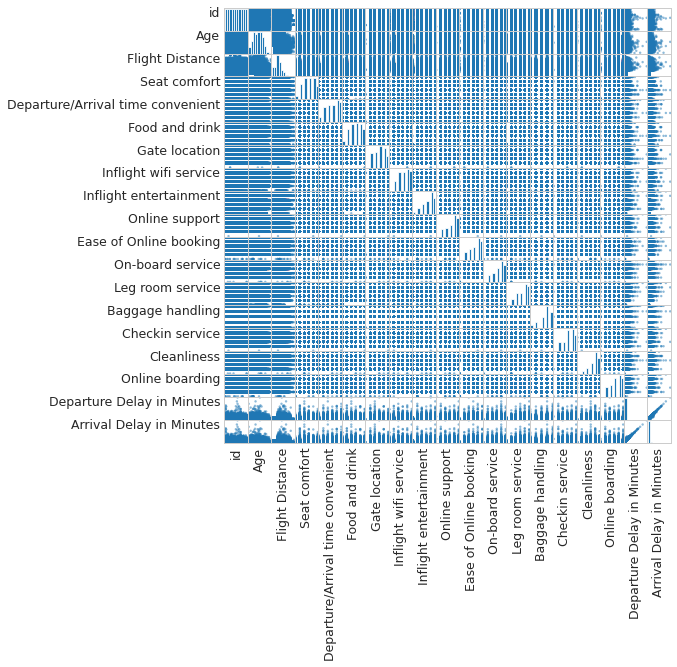

In [40]:
numeric_features = [t[0] for t in df.dtypes 
                    if t[1] == 'int' ]

numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));

# Rotate axis labels and remove axis ticks
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

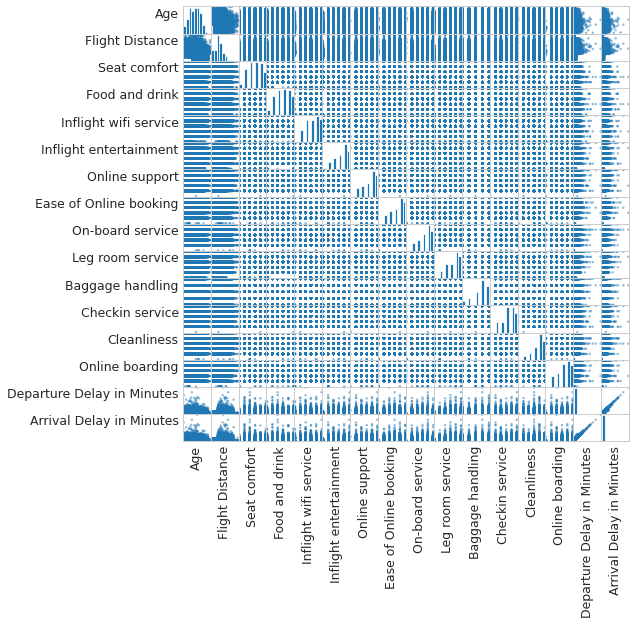

In [41]:
useful_features = []

for i in df.dtypes:
    if i[1] == 'int' and i[0] not in ['id', 'Departure/Arrival time convenient', 'Gender', 'Gate location']:
        useful_features.append(i[0])
        
numeric_data = df.select(useful_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));

# Rotate axis labels and remove axis ticks
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())
    

In [42]:
useful_features.append('satisfaction_v2')
useful_features.append('Customer Type')
useful_features.append('Type of Travel')
useful_features.append('Class')
df = df.select(useful_features)
cols = df.columns 
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- Online support: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Departure Delay in Minutes: integer (nullable = true)
 |-- Arrival Delay in Minutes: integer (nullable = true)
 |-- satisfaction_v2: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)



# Preparing Data for Machine Learning

In [68]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ['Customer Type', 'Type of Travel', 'Class']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'satisfaction_v2', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Seat comfort', 'Food and drink', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# Pipeline

In [69]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

IllegalArgumentException: requirement failed: Output column label already exists.

In [70]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,0,0,0,0,0
features,"[1.0, 0.0, 0.0, 1.0, 65.0, 265.0, 0.0, 0.0, 0....","[1.0, 0.0, 1.0, 0.0, 47.0, 2464.0, 310.0, 305....","[1.0, 0.0, 0.0, 1.0, 15.0, 2138.0, 0.0, 0.0, 0...","[1.0, 0.0, 0.0, 1.0, 60.0, 623.0, 0.0, 0.0, 0....","[1.0, 0.0, 0.0, 1.0, 70.0, 354.0, 0.0, 0.0, 0...."
Age,65,47,15,60,70
Flight Distance,265,2464,2138,623,354
Seat comfort,0,0,0,0,0
Food and drink,0,0,0,0,0
Inflight wifi service,2,0,2,3,4
Inflight entertainment,4,2,0,4,3
Online support,2,2,2,3,4
Ease of Online booking,3,3,2,1,2


In [71]:
train.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- Online support: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Departure Delay in Minutes: integer (nullable = true)
 |-- Arrival Delay in Minutes: integer (nullable = true)
 |-- satisfaction_v2: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Type of Travel: string (nullab

In [72]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + train.count())
print("Test Dataset Count: " + test.count())

Py4JJavaError: An error occurred while calling o1761.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 78.0 failed 1 times, most recent failure: Lost task 1.0 in stage 78.0 (TID 1390, acae530d2ee5, executor driver): org.apache.spark.SparkException: Failed to execute user defined function(VectorAssembler$$Lambda$3532/0x0000000841365840: (struct<Customer TypeclassVec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,Type of TravelclassVec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,ClassclassVec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,Age_double_VectorAssembler_b8c12f38983b:double,Flight Distance_double_VectorAssembler_b8c12f38983b:double,Departure Delay in Minutes_double_VectorAssembler_b8c12f38983b:double,Arrival Delay in Minutes_double_VectorAssembler_b8c12f38983b:double,Seat comfort_double_VectorAssembler_b8c12f38983b:double,Food and drink_double_VectorAssembler_b8c12f38983b:double,Inflight wifi service_double_VectorAssembler_b8c12f38983b:double,Inflight entertainment_double_VectorAssembler_b8c12f38983b:double,Online support_double_VectorAssembler_b8c12f38983b:double,Ease of Online booking_double_VectorAssembler_b8c12f38983b:double,On-board service_double_VectorAssembler_b8c12f38983b:double,Leg room service_double_VectorAssembler_b8c12f38983b:double,Baggage handling_double_VectorAssembler_b8c12f38983b:double,Checkin service_double_VectorAssembler_b8c12f38983b:double,Cleanliness_double_VectorAssembler_b8c12f38983b:double,Online boarding_double_VectorAssembler_b8c12f38983b:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.agg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 17 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2023)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1972)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1971)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1971)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:950)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2203)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2152)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2141)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:752)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2093)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2114)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2133)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1004)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1003)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:385)
	at org.apache.spark.sql.Dataset.$anonfun$count$1(Dataset.scala:2979)
	at org.apache.spark.sql.Dataset.$anonfun$count$1$adapted(Dataset.scala:2978)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3616)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:100)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:160)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:87)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:763)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3614)
	at org.apache.spark.sql.Dataset.count(Dataset.scala:2978)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function(VectorAssembler$$Lambda$3532/0x0000000841365840: (struct<Customer TypeclassVec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,Type of TravelclassVec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,ClassclassVec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,Age_double_VectorAssembler_b8c12f38983b:double,Flight Distance_double_VectorAssembler_b8c12f38983b:double,Departure Delay in Minutes_double_VectorAssembler_b8c12f38983b:double,Arrival Delay in Minutes_double_VectorAssembler_b8c12f38983b:double,Seat comfort_double_VectorAssembler_b8c12f38983b:double,Food and drink_double_VectorAssembler_b8c12f38983b:double,Inflight wifi service_double_VectorAssembler_b8c12f38983b:double,Inflight entertainment_double_VectorAssembler_b8c12f38983b:double,Online support_double_VectorAssembler_b8c12f38983b:double,Ease of Online booking_double_VectorAssembler_b8c12f38983b:double,On-board service_double_VectorAssembler_b8c12f38983b:double,Leg room service_double_VectorAssembler_b8c12f38983b:double,Baggage handling_double_VectorAssembler_b8c12f38983b:double,Checkin service_double_VectorAssembler_b8c12f38983b:double,Cleanliness_double_VectorAssembler_b8c12f38983b:double,Online boarding_double_VectorAssembler_b8c12f38983b:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.agg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 17 more


# Logistic Regression Model

In [64]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
model_1 = lr.fit(train)

Py4JJavaError: An error occurred while calling o1416.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 68.0 failed 1 times, most recent failure: Lost task 1.0 in stage 68.0 (TID 1366, acae530d2ee5, executor driver): org.apache.spark.SparkException: Failed to execute user defined function(VectorAssembler$$Lambda$3532/0x0000000841365840: (struct<Customer TypeclassVec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,Type of TravelclassVec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,ClassclassVec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,Age_double_VectorAssembler_b8c12f38983b:double,Flight Distance_double_VectorAssembler_b8c12f38983b:double,Departure Delay in Minutes_double_VectorAssembler_b8c12f38983b:double,Arrival Delay in Minutes_double_VectorAssembler_b8c12f38983b:double,Seat comfort_double_VectorAssembler_b8c12f38983b:double,Food and drink_double_VectorAssembler_b8c12f38983b:double,Inflight wifi service_double_VectorAssembler_b8c12f38983b:double,Inflight entertainment_double_VectorAssembler_b8c12f38983b:double,Online support_double_VectorAssembler_b8c12f38983b:double,Ease of Online booking_double_VectorAssembler_b8c12f38983b:double,On-board service_double_VectorAssembler_b8c12f38983b:double,Leg room service_double_VectorAssembler_b8c12f38983b:double,Baggage handling_double_VectorAssembler_b8c12f38983b:double,Checkin service_double_VectorAssembler_b8c12f38983b:double,Cleanliness_double_VectorAssembler_b8c12f38983b:double,Online boarding_double_VectorAssembler_b8c12f38983b:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1371)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1298)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1362)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1186)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:360)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:311)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 26 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2023)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1972)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1971)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1971)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:950)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2203)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2152)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2141)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:752)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2093)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2188)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1157)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1151)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1220)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1196)
	at org.apache.spark.ml.classification.LogisticRegression.$anonfun$train$1(LogisticRegression.scala:504)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:492)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:487)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:277)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:150)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function(VectorAssembler$$Lambda$3532/0x0000000841365840: (struct<Customer TypeclassVec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,Type of TravelclassVec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,ClassclassVec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,Age_double_VectorAssembler_b8c12f38983b:double,Flight Distance_double_VectorAssembler_b8c12f38983b:double,Departure Delay in Minutes_double_VectorAssembler_b8c12f38983b:double,Arrival Delay in Minutes_double_VectorAssembler_b8c12f38983b:double,Seat comfort_double_VectorAssembler_b8c12f38983b:double,Food and drink_double_VectorAssembler_b8c12f38983b:double,Inflight wifi service_double_VectorAssembler_b8c12f38983b:double,Inflight entertainment_double_VectorAssembler_b8c12f38983b:double,Online support_double_VectorAssembler_b8c12f38983b:double,Ease of Online booking_double_VectorAssembler_b8c12f38983b:double,On-board service_double_VectorAssembler_b8c12f38983b:double,Leg room service_double_VectorAssembler_b8c12f38983b:double,Baggage handling_double_VectorAssembler_b8c12f38983b:double,Checkin service_double_VectorAssembler_b8c12f38983b:double,Cleanliness_double_VectorAssembler_b8c12f38983b:double,Online boarding_double_VectorAssembler_b8c12f38983b:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1371)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1298)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1362)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1186)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:360)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:311)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 26 more
